# 2.3. Малое количество объектов


In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Entered by the user

In [72]:
n_points = 100 # Data quantity
centroids_residual = 0.001 # Residual for checking centroids
elbow_residual = 0.001 # Residual for checking centroids

# Default parameters

In [73]:
k = 1  # Clusters number (centers number)
exit_condition = False

#for plots of clusters distribution
xlim_min = -0.2
xlim_max = 1.2
ylim_min = -0.2
ylim_max = 1.2

# Data initialization

Вход:

$\{x_{1},...,x_{m}\}\subseteq R^n$

In [74]:
points = np.random.rand(n_points,2)
#points = np.array([[1,2], [2,3], [3,3], [4,4], [7,5], [8,6], [9,7], [8,8], [9,9], [10,10]])
#points = [[int(i) for j in range(2)] for i in range(10)]

In [75]:
#print(points)

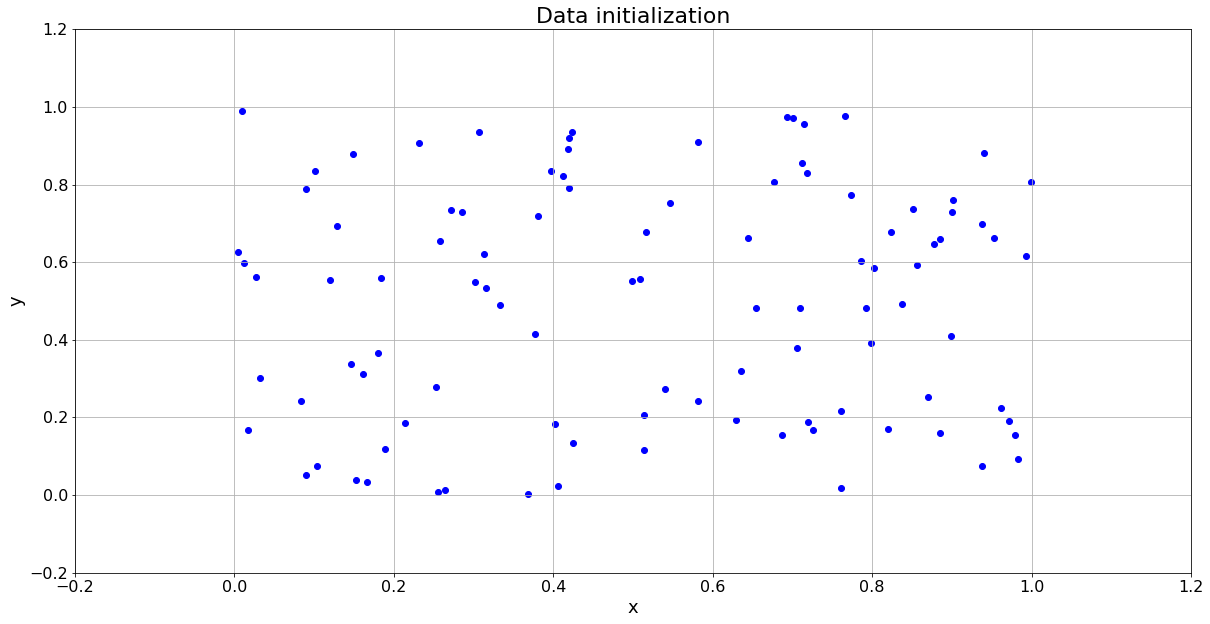

In [76]:
#plt.axes(xlim=(xlim_min, xlim_max), ylim=(ylim_min, ylim_max))
plt.figure(figsize = (20,10))
plt.title('Data initialization', fontsize = 22)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
plt.grid(True)
plt.scatter(points[:,0], points[:,1], c = 'blue')
plt.xticks(np.linspace(xlim_min, xlim_max, 8), fontsize = 16)
plt.yticks(np.linspace(ylim_min, ylim_max, 8), fontsize = 16);

Инициализация k центров кластеров.

$\{\mu_{1},...,\mu_{k}\}\subseteq R^n$

In [77]:
def initialize_centroids(data, k):
    dist = []
    centroids = np.zeros((k, 2))
    random_n = []
    n = 0
    i = 0
    dist = np.sqrt(np.sum(data**2, axis = 1))
    if k >= 3:
        centroids[0] = data[np.argmax(dist)]
        random_n.append(np.argmax(dist))
        k -= 1
        if np.argmin(dist) not in random_n:
            centroids[1] = data[np.argmin(dist)]
            random_n.append(np.argmin(dist))
            k -= 1
            if (len(data) // 2) not in random_n:
                centroids[2] = data[len(data) // 2]
                random_n.append(len(data) // 2)
                k -= 1
                i = 3
                while k != 0:
                    n = np.random.randint(0, (len(data) - 1))
                    if n not in random_n:
                        random_n.append(n)
                        centroids[i] = data[n]
                        k -= 1
                        i += 1
                    else:
                        continue
            else:
                while k != 0:
                    n = np.random.randint(0, (len(data) - 1))
                    if n not in random_n:
                        random_n.append(n)
                        centroids[i] = data[n]
                        k -= 1
                        i += 1
                    else:
                        continue
        else:
            while k != 0:
                n = np.random.randint(0, (len(data) - 1))
                if n not in random_n:
                    random_n.append(n)
                    centroids[i] = data[n]
                    k -= 1
                    i += 1
                else:
                    continue
                
    elif k == 1:
        centroids[0] = data[np.argmax(dist)]
    elif k == 2:
        centroids[0] = data[np.argmax(dist)]
        centroids[1] = data[np.argmin(dist)]
    return centroids

In [78]:
def initialize_centroids_randow(data, k):
    dist = []
    centroids = np.zeros((k, 2))
    random_n = []
    n = 0
    i = 0
    while k != 0:
        n = np.random.randint(0, (len(data) - 1))
        if n not in random_n:
            random_n.append(n)
            centroids[i] = data[n]
            k -= 1
            i += 1
        else:
            continue
    return centroids

Нахождение ближайшего центроида к каждой точке (assignment). Каждый объект приписать к тому кластеру, к центру которого он ближе

$С_{t} = \{i\mid k=argmin\parallel x_{i} - \mu_{t}\parallel^2$\}

In [79]:
def closest_centroids(points, centroids, n_points, k):
    dist = np.zeros((n_points, k))
    #print(dist)
    for i in range(n_points):
        for j in range(k):
            dist[i][j] = np.sqrt(((points[i][0] - centroids[j][0]) ** 2) + ((points[i][1] - centroids[j][1]) ** 2))    
    #print(dist)
    return np.argmin(dist, axis = 1)

Пересчет центров кластеров (update). Подсчитывается среднеарифметическое значение для каждого центра кластера. При неопределённости вида "деление на ноль" оставляем центр неизменным.

$\mu_{t} = \frac {1}{|C_{t}|}\sum_{i\in C_{t}}  x_{i}$

In [80]:
def move_centroids(points, centroids, closest_points, k):
    new_centroids = np.zeros((k, 2))   
    new_centroids = np.array([points[closest_points==i].mean(axis=0) if i in closest_points else centroids[i] for i in range(centroids.shape[0])])
    return new_centroids

Расчёт невязки. Подсчитывается разность между текущими новыми и предыдущими центроидами. Значение невязки задаётся в программе

$\mu_{cur} - \mu_{prev} < \mu_{residual}$

In [81]:
def residual_check(new_centroids, centroids, residual):
    result = True
    residual_arr = np.absolute(new_centroids - centroids)
    checking = np.zeros((residual_arr.shape[0], residual_arr.shape[1]))
    for i in range(residual_arr.shape[0]):
        for j in range(residual_arr.shape[1]):
            if residual_arr[i][j] <= residual:
                checking[i][j] = True
            else:
                checking[i][j] = False  
    #print(checking)
    for i in range(checking.shape[0]):
        for j in range(checking.shape[1]):
            if checking[i][j] == False:
                result = False
            else:
                continue
    return result

Метод Elbow - метод локтя. Вычисляется сумма квадратов расстояний от каждой точки до центра кластера, которому он принадлежит. Далее возвращется средне арифметическое, т.е. общая сумма делится на число кластеров k.

$SSE = \sum_{i=1}^{k}\sum_{p\in C_{i}} |p - x_{i}|^2$

In [82]:
def elbow_function(points, centroids, closest_points, k):
    result = 0   
    for i in range(k):
        for j in range(len(closest_points)):
            if i == closest_points[j]:
                result += np.sqrt(((points[j][0] - centroids[i][0]) ** 2) + ((points[j][1] - centroids[i][1]) ** 2)) ** 2
    return (result / k)

 Метод Elbow - метод "локтя". С помощью данного методы вычисляется оптимальное количество кластеров. На каждой итерации значение суммы квадратов расстояний до каждого кластера будет уменьшаться, то есть в какой-то момент значение функции будет слабо изменяться, что означает достижении оптимального числа кластеров. В алгоритм ниже добавлена невязка для останова.

In [83]:
elbow_dist = np.array([])
k_final = 0
prev = 100
print('Iteration number (clusters number) = ', k)
#centroids = initialize_centroids(points, k)
centroids = initialize_centroids_randow(points, k)
closest_points = closest_centroids(points, centroids, n_points, k)
dist = elbow_function(points, centroids, closest_points, k)
elbow_dist = np.append(elbow_dist, dist)
prev = np.copy(dist)
k += 1
#print(elbow_dist)
#K = range(2, 100, 1)
while True:
    print('Iteration number (clusters number) = ', k)
    #centroids = initialize_centroids(points, k)
    centroids = initialize_centroids_randow(points, k)
    closest_points = closest_centroids(points, centroids, n_points, k)
    dist = elbow_function(points, centroids, closest_points, k)
    #elbow_dist = np.append(elbow_dist, dist)
    if np.absolute(dist - prev) < elbow_residual:
        k_final = k
        elbow_dist = np.append(elbow_dist, dist)
        break
    else:
        prev = np.copy(dist)
        elbow_dist = np.append(elbow_dist, dist)
        k += 1
        
print('Elbow method function')
print(elbow_dist)
print('Clusters optimum number = ', k_final)

Iteration number (clusters number) =  1
Iteration number (clusters number) =  2
Iteration number (clusters number) =  3
Iteration number (clusters number) =  4
Iteration number (clusters number) =  5
Iteration number (clusters number) =  6
Iteration number (clusters number) =  7
Iteration number (clusters number) =  8
Iteration number (clusters number) =  9
Iteration number (clusters number) =  10
Iteration number (clusters number) =  11
Iteration number (clusters number) =  12
Iteration number (clusters number) =  13
Iteration number (clusters number) =  14
Iteration number (clusters number) =  15
Iteration number (clusters number) =  16
Iteration number (clusters number) =  17
Iteration number (clusters number) =  18
Iteration number (clusters number) =  19
Iteration number (clusters number) =  20
Iteration number (clusters number) =  21
Iteration number (clusters number) =  22
Iteration number (clusters number) =  23
Iteration number (clusters number) =  24
Iteration number (cluster

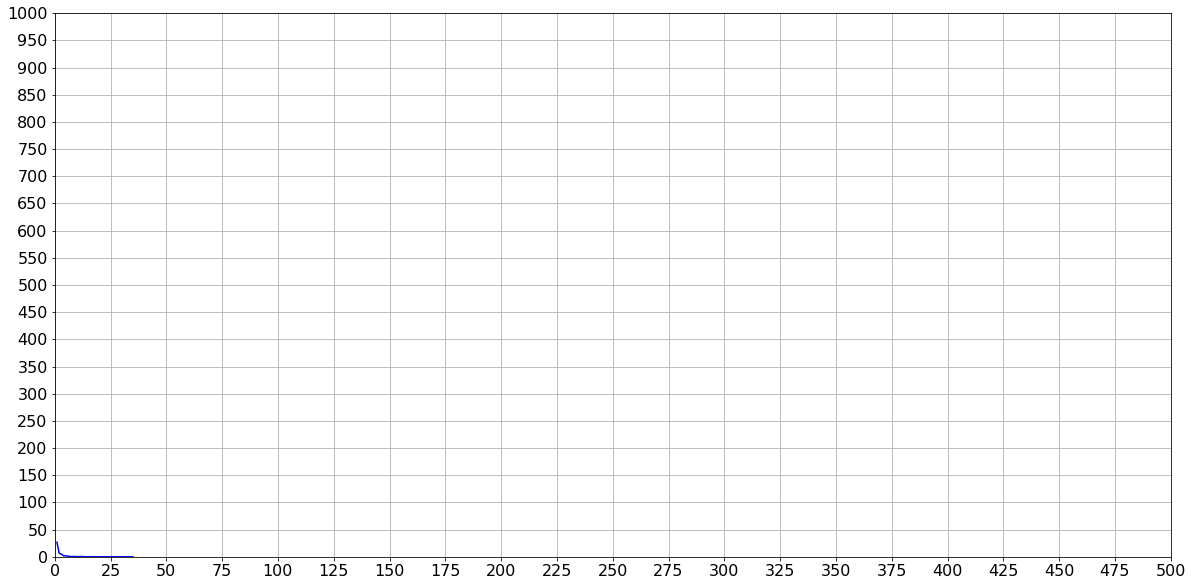

In [84]:
K = range(1, k_final + 1)
K = np.array(K)
#print(K)
#print(K[len(K) - 1])

plt.figure(figsize = (20,10))
plt.title('Elbow method (choosing the value of k)', fontsize = 22)
plt.xlabel('k (number of clusters)', fontsize = 18)
plt.ylabel('Elbow function SSE', fontsize = 18)
plt.axes(xlim=(0, K[len(K) - 1] + 1), ylim=(0, 1000))
plt.grid(True)
plt.plot(K, elbow_dist, c = 'blue')
plt.xticks(np.linspace(0, 500, 21), fontsize = 16)
plt.yticks(np.linspace(0, 1000, 21), fontsize = 16);
#plt.xticks([int(5*i) for i in range(1, 10)])
#plt.yticks([int(50*i) for i in range(1, 20)])
#plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])


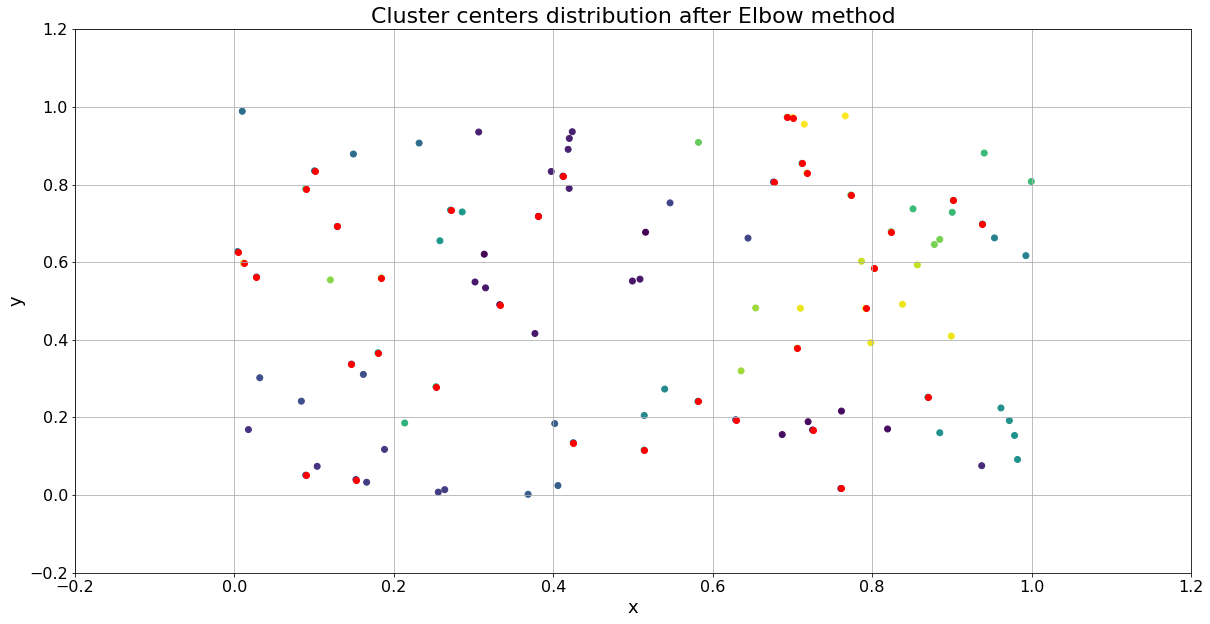

In [85]:
plt.figure(figsize = (20,10))
#plt.axes(xlim=(xlim_min, xlim_max), ylim=(ylim_min, ylim_max))
plt.title('Cluster centers distribution after Elbow method', fontsize = 22)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
#plt.title('Cluster centers distribution after Elbow method', fontsize = 22)
plt.grid(True)
plt.scatter(points[:,0], points[:,1], c = closest_points)
plt.scatter(centroids[:,0], centroids[:,1], c = 'red')
plt.xticks(np.linspace(xlim_min, xlim_max, 8), fontsize = 16)
plt.yticks(np.linspace(ylim_min, ylim_max, 8), fontsize = 16);

In [86]:
new_centroids = move_centroids(points, centroids, closest_points, k_final)
print(new_centroids)
print(centroids)

[[0.40357267 0.67190549]
 [0.74266209 0.18000798]
 [0.38917484 0.5162395 ]
 [0.39982572 0.87507686]
 [0.84915665 0.04646993]
 [0.07034275 0.09819655]
 [0.20527933 0.04265077]
 [0.62240503 0.7404448 ]
 [0.10615284 0.29821125]
 [0.6288205  0.19432837]
 [0.40035027 0.0865651 ]
 [0.02772675 0.56182506]
 [0.12287543 0.90230516]
 [0.0039688  0.62735935]
 [0.12905529 0.69208823]
 [0.96162358 0.65915393]
 [0.5451554  0.24005708]
 [0.94165117 0.17916643]
 [0.27160868 0.70627558]
 [0.51397008 0.11613331]
 [0.18012119 0.36669969]
 [0.71202432 0.85463352]
 [0.23325362 0.23253638]
 [0.91884571 0.78273275]
 [0.08949936 0.78884309]
 [0.77331269 0.77311334]
 [0.63781437 0.94088687]
 [0.86226793 0.6608472 ]
 [0.15234104 0.55694663]
 [0.66518033 0.39352313]
 [0.71820971 0.82946412]
 [0.81550643 0.59304909]
 [0.01152484 0.59781368]
 [0.80756636 0.45125008]
 [0.7272295  0.9681704 ]]
[[0.38142977 0.71806381]
 [0.72538091 0.16794366]
 [0.33286564 0.49059517]
 [0.41213612 0.82154638]
 [0.76079163 0.01710851]

In [87]:
closest_points = closest_centroids(points, new_centroids, n_points, k_final)
print(closest_points)

[12 27  3  6 28 31 27 18 30 12  3 23 25  2 11 20 34  8 21 10 29  2 29 31
 15  5  0 32 17  6 29 34  6  1  3 22 13 16  4 16 33 23 16  4 19  0  9 29
 17  3  2  1  5 17 22 23 12 18  8 27 34  1  1 28  8  3  6 18 33  6 17  5
  2  3  3 24 10  2 15 20  2 10  1  7 27 31 15 33 33 26  7 34 24 23 14 30
 10 18 17 17]


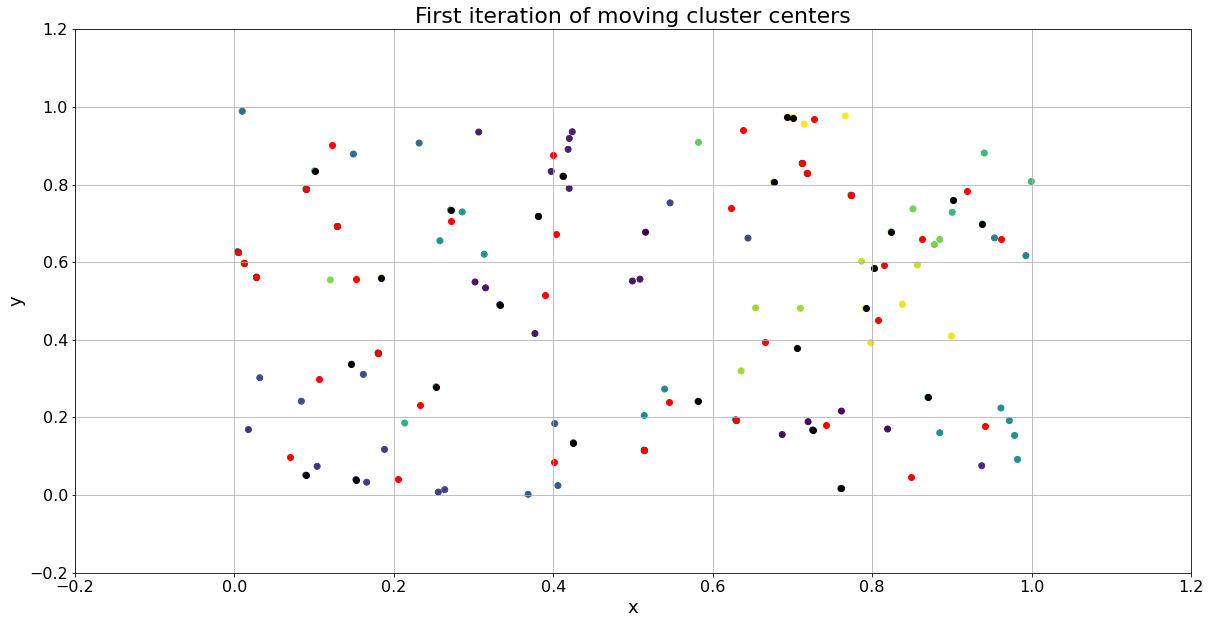

In [88]:
plt.figure(figsize = (20,10))
#plt.axes(xlim=(xlim_min, xlim_max), ylim=(ylim_min, ylim_max))
plt.title('First iteration of moving cluster centers', fontsize = 22)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
plt.grid(True)
plt.scatter(points[:,0], points[:,1], c = closest_points)
plt.scatter(centroids[:,0], centroids[:,1], c = 'black')
plt.scatter(new_centroids[:,0], new_centroids[:,1], c = 'red')
plt.xticks(np.linspace(xlim_min, xlim_max, 8), fontsize = 16)
plt.yticks(np.linspace(ylim_min, ylim_max, 8), fontsize = 16);

In [89]:
iteration = 1
exit_condition = residual_check(new_centroids, centroids, centroids_residual)
print('Iteration number = ', iteration, end = ' ')
print(exit_condition)
while exit_condition == False:
    iteration += 1
    prev_centroids = np.copy(new_centroids)
    new_centroids = move_centroids(points, prev_centroids, closest_points, k_final)
    closest_points = closest_centroids(points, new_centroids, n_points, k_final)    
    exit_condition = residual_check(new_centroids, prev_centroids, centroids_residual)
    print('Iteration number = ', iteration, end = ' ')
    print(exit_condition)
print('Final centroids')
print(new_centroids)
print('Closest_points')
print(closest_points)

Iteration number =  1 False
Iteration number =  2 False
Iteration number =  3 False
Iteration number =  4 True
Final centroids
[[0.44862816 0.69759043]
 [0.74266209 0.18000798]
 [0.38917484 0.5162395 ]
 [0.39982572 0.87507686]
 [0.84915665 0.04646993]
 [0.07034275 0.09819655]
 [0.20527933 0.04265077]
 [0.59542363 0.70738504]
 [0.05793953 0.27216029]
 [0.6288205  0.19432837]
 [0.40035027 0.0865651 ]
 [0.02772675 0.56182506]
 [0.1303219  0.92466014]
 [0.0039688  0.62735935]
 [0.12905529 0.69208823]
 [0.96162358 0.65915393]
 [0.5451554  0.24005708]
 [0.94165117 0.17916643]
 [0.28207194 0.68484059]
 [0.51397008 0.11613331]
 [0.16295117 0.33840803]
 [0.71202432 0.85463352]
 [0.23325362 0.23253638]
 [0.94745916 0.81599531]
 [0.09501769 0.81204166]
 [0.77331269 0.77311334]
 [0.58219925 0.90853765]
 [0.86773097 0.68964389]
 [0.15234104 0.55694663]
 [0.67639868 0.41548904]
 [0.69728877 0.81801423]
 [0.81550643 0.59304909]
 [0.01152484 0.59781368]
 [0.83194451 0.4437159 ]
 [0.7187795  0.96943682

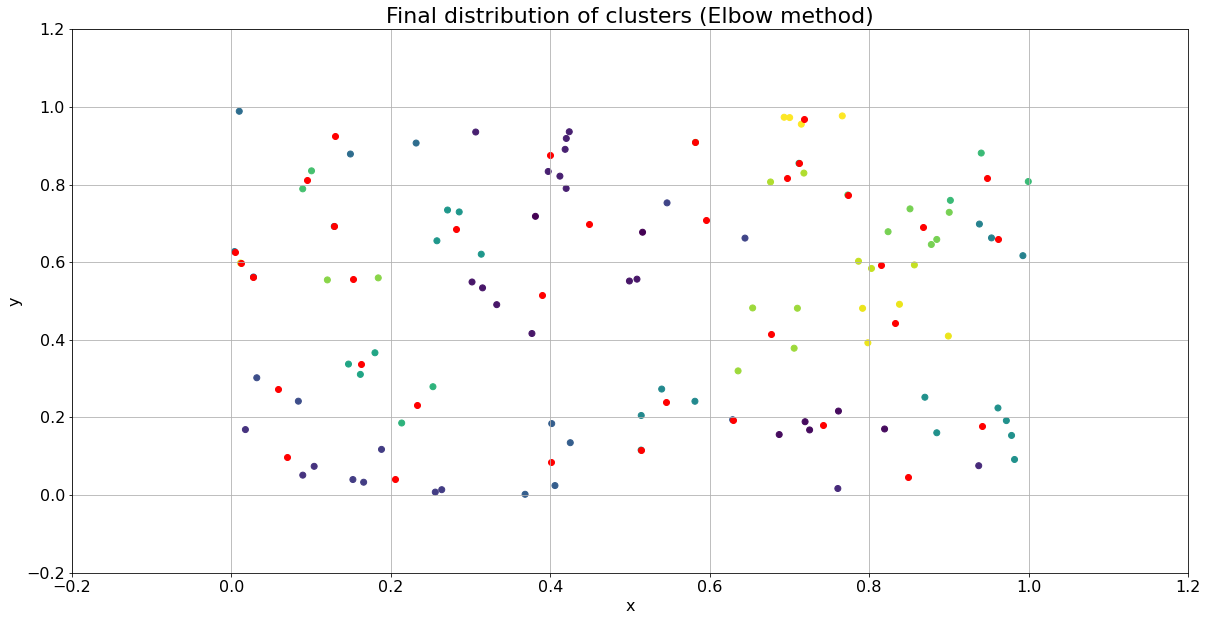

In [90]:
#plt.axes(xlim=(xlim_min, xlim_max), ylim=(ylim_min, ylim_max))
plt.figure(figsize = (20,10))
plt.title('Final distribution of clusters (Elbow method)', fontsize = 22)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
plt.grid(True)
plt.scatter(points[:,0], points[:,1], c = closest_points)
plt.scatter(new_centroids[:,0], new_centroids[:,1], c = 'red')
plt.xticks(np.linspace(xlim_min, xlim_max, 8), fontsize = 16)
plt.yticks(np.linspace(ylim_min, ylim_max, 8), fontsize = 16);

# Вывод.
Количество оптимальных кластеров сравнимо с заданным количество объектов и не всегда может привести к решению, если задана высокая точность определения функции "локтя". В данном примере при 10 объектах и заданной точности не получилось получить количество кластеров меньше числа объектов. Для решения задачи количество объектов было увеличено до 100 и получено 35 кластеров.